Derive spec2vec embeddings of MS/MS spectra

In [1]:
import os
import sys
import gensim
import numpy as np

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\Gosia\\Desktop\\'
sys.path.insert(0, ROOT)

In [2]:
import passatuto_parser as pp
sys.path.append('C:\\Users\\Gosia\\Desktop\\FDR-Metabolomics\\src\\passatuto_parser.py')


pre_spectrums_query = pp.PassatutoParser(r'C:\\Users\\Gosia\\Desktop\\MassbankOrbi').parse_folder()
pre_spectrums_lib = pp.PassatutoParser('C:\\Users\\Gosia\\Desktop\\Gnps_Noise_Filtered').parse_folder()

# Using MatchMS to create spectra for both
from matchms.importing.load_from_json import as_spectrum
spectrums_query = []
for i, s in enumerate( pre_spectrums_query ):
    spectrums_query.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)
        
spectrums_lib = []
for i, s in enumerate( pre_spectrums_lib ):
    spectrums_lib.append(as_spectrum(s))
    if i and i % 100 == 0:
        print('processed %d' % i)

processed 100 files
processed 200 files
processed 300 files
processed 400 files
Finished parsing of 457 spectra 
processed 100 files
processed 200 files
processed 300 files
processed 400 files
processed 500 files
processed 600 files
processed 700 files
processed 800 files
processed 900 files
processed 1000 files
processed 1100 files
processed 1200 files
processed 1300 files
processed 1400 files
processed 1500 files
processed 1600 files
processed 1700 files
processed 1800 files
processed 1900 files
processed 2000 files
processed 2100 files
processed 2200 files
processed 2300 files
processed 2400 files
processed 2500 files
processed 2600 files
processed 2700 files
processed 2800 files
processed 2900 files
processed 3000 files
processed 3100 files
processed 3200 files
processed 3300 files
processed 3400 files
processed 3500 files
processed 3600 files
processed 3700 files
processed 3800 files
processed 3900 files
processed 4000 files
Finished parsing of 4095 spectra 
processed 100
processe

In [3]:
from matchms.filtering import normalize_intensities
# Spec2Vec trained model requires normalizing
spectrums_query = [normalize_intensities(s) for s in spectrums_query]
spectrums_lib = [normalize_intensities(s) for s in spectrums_lib]

Create spectrum "documents"

In [4]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument

documents_query = [SpectrumDocument(s, n_decimals=2) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=2) for s in spectrums_lib]
print(documents_query)


[<spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24DB75CD0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24BC19D60>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24BC19C40>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24BC19C10>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24BC19580>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D2482579D0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D2482578B0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24BC228E0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24BC220A0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24BC1DBB0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24BC1DC10>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24BC1DBE0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24BC1DAF0>, <spec2vec.SpectrumDocume

In [126]:
from spec2vec.model_building import train_new_word2vec_model
path_models = os.path.join(path_data, "trained_models")

model_file = os.path.join(path_models, "spec2vec_librarymatching_size_3.model")

iterations = [1, 3, 5, 10]

#Train model with size 10 and default parameters

model = train_new_word2vec_model(documents_lib, iterations, model_file, size = 3)

The value of size is set from 300 (default) to 3
  Epoch 1 of 10.Change in loss after epoch 1: 103382.640625
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_librarymatching_size_3_iter_1.model
  Epoch 2 of 10.Change in loss after epoch 2: 77580.578125
  Epoch 3 of 10.Change in loss after epoch 3: 72245.796875
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_librarymatching_size_3_iter_3.model
  Epoch 4 of 10.Change in loss after epoch 4: 67973.828125
  Epoch 5 of 10.Change in loss after epoch 5: 67037.65625
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_librarymatching_size_3_iter_5.model
  Epoch 6 of 10.Change in loss after epoch 6: 64555.9375
  Epoch 7 of 10.Change in loss after epoch 7: 63923.625
  Epoch 8 of 10.Change in loss after epoch 8: 64757.1875
  Epoch 9 of 10.Change in loss after epoch 9: 63123.625
  Epoch 10 of 10.Change in loss after epoch 10: 65471.25
Saving model with name: C:\Users\Gosia\Desktop\train


Derive embeddings

In [127]:
from tqdm.notebook import tqdm  # optional, just to get a progress bar
from spec2vec.vector_operations import calc_vector


intensity_weighting_power = 0.5
allowed_missing_percentage = 80 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

vector_size = model.vector_size
print(f"Embedding vector size: {vector_size}")

embeddings_spec2vec_lib = np.zeros((len(documents_lib), vector_size), dtype="float")
for i, doc in enumerate(tqdm(documents_lib)):
    embeddings_spec2vec_lib[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

Embedding vector size: 3


In [128]:
embeddings_spec2vec_query = embeddings_spec2vec_lib

In [129]:
print([np.round(x, 4) for x in embeddings_spec2vec_lib])

[array([ 4.2472, -1.4969,  1.4558]), array([12.5549, 12.9817,  0.8734]), array([6.0819, 5.437 , 0.6179]), array([ 4.1629,  4.9214, -6.0346]), array([  8.174 , -10.621 , -10.9281]), array([ 1.1349,  1.8256, -0.6227]), array([ 3.3296,  2.5226, -1.1701]), array([21.3807,  9.1614,  8.4998]), array([ 4.0987, -1.2758,  1.9761]), array([6.0494, 1.2667, 2.959 ]), array([21.3167, 23.716 ,  0.1288]), array([14.5775,  8.4569,  5.4171]), array([11.0561,  6.5405,  2.2016]), array([11.7569, 11.9828,  0.4933]), array([ 4.5025,  2.805 , -2.9292]), array([11.5673,  7.9627, -2.0138]), array([ 9.99  ,  8.8001, -0.3969]), array([ 3.7315,  4.5814, -2.9215]), array([ 0.749 ,  3.4245, -1.486 ]), array([17.2203, -0.0824,  9.0565]), array([6.0028, 1.3726, 0.33  ]), array([12.8307, -0.8204, -2.8135]), array([ 6.4064,  9.689 , -0.2623]), array([  3.9968,   5.3261, -12.0384]), array([ 1.2423,  1.4607, -4.7687]), array([ 2.4407,  5.2087, -7.3977]), array([ 2.0632,  2.7048, -2.4912]), array([11.3965,  5.2561, -1.00

In [130]:
import numpy as np
from sklearn.mixture import GaussianMixture

gm = GaussianMixture().fit(embeddings_spec2vec_lib)
gm.means_
gm.covariances_[0]

(array([ 19.26725964,   0.26457944, -19.07243796]),
 array([23.40873254, -2.01962524, -4.92133663]))

# Creating knockoffs


In [146]:
import copy
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
from matplotlib import cm
from scipy.stats import multivariate_normal
from spec2vec.SpectrumDocument import SpectrumDocument
from matchms import Spectrum


def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

# seed(1234)
nDim = len(embeddings_spec2vec_lib[0])
# define the mean and covariance 
mu = gm.means_[0]
Sigma = gm.covariances_[0]
D = np.eye(nDim)*0.16

joint_cov = np.hstack((Sigma, Sigma-D))
joint_cov = np.vstack((joint_cov, np.hstack((Sigma-D,Sigma))))

print(is_pos_def(joint_cov))

A = np.eye(nDim) - np.dot(D,np.linalg.inv(Sigma))

all_knockoffs = []
# generate a sample
for point in embeddings_spec2vec_lib:
    # generate N knock-offs
    kmu = np.dot(np.dot(D,np.linalg.inv(Sigma)),mu)
    B = np.dot(A, point.T)
    kmu += B
    kSigma = 2*D - np.dot(np.dot(D,np.linalg.inv(Sigma)), D)
    ko = np.random.multivariate_normal(kmu.flatten(), kSigma, 1)
    all_knockoffs.append(ko)


knockoff_documents = []
for ko,v,d in zip(all_knockoffs,embeddings_spec2vec_lib,documents_lib):
    #print("knockoff:",ko,"vector",v,"document",d)
    #print("\n")
    e = copy.deepcopy(d)
    e._obj.set('inchi', 'knockoff')
    e._obj.set('vector', ko[0])
    knockoff_documents.append(e)
print(knockoff_documents)

True
[<spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D251985E20>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D251985C10>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D251985310>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24FE69F40>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24FE69490>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24FE691C0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24FE9CEB0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24FE9C8E0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24FE9C9D0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D2518B9E20>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D2518B9EB0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D2518B93D0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000001D24FE4B5B0>, <spec2vec.SpectrumD

In [147]:
import importlib
import cosine_calc
importlib.reload(cosine_calc)
hits_knockoffs, _ = cosine_calc.get_hits(documents_query, knockoff_documents, decoys=True, spec2vec_model=model,
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage)
hits, _ = cosine_calc.get_hits(documents_query, documents_lib, spec2vec_model=model,
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage)


Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) mi

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.60%.
Found 13 word(s) missing in 

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.88%.
Found 11 word(s) missing in 

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.43%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.43%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.43%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.43%.
Found 24 word(s) missing in t

Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.99%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.99%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.99%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.99%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.99%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.99%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.99%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.26%.
Found 69 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.37%.
Found 69 word(s) mis

Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) mi

Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.22%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.22%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.22%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.22%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.22%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.22%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.22%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.22%.
Found 78 word(s) missing in the model. Weighted missing percentage not covered by the given model is 37.22%.
Found 78 word(s) mi

Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 83 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.19%.
Found 83 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.19%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.33%.
Found 3 word(s) missi

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model.

Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.77%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.77%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.77%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.77%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.77%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.77%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.77%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.77%.
Found 130 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.77%.
Found 130 

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.90%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 20.90%.
Found 56 word(s) missing in the m

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.48%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.48%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 8 word(s) missing in the mode

Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.16%.
Found 40 word(s) missing in 

Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.89%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.89%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.89%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.89%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.89%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.89%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.89%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.89%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.89%.
Found 19 word(s) missing in 

Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.25%.
Found 16 word(s) missing in 

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model.

Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 23 word(s) mi

Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.11%.
Found 16 word(s) missing in 

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.97%.
Found 6 word(s) missing in the model.

Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.47%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.47%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.47%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.47%.
Found 27 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.47%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.05%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.05%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.05%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.05%.
Found 17 word(s) missing in 

Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.22%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.22%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.22%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.22%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.22%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.22%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in 

Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in 

Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.16%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.16%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.16%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.16%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.16%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.16%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.16%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.16%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.16%.
Found 49 word(s) mi

Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.50%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.50%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.50%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.50%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.50%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.50%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.50%.
Found 18 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.50%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.52%.
Found 42 word(s) missing in 

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.30%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.30%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.31%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.31%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.31%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.14%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.14%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.14%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.14%.
Found 14 word(s) missing 

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.06%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.06%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.06%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.06%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in 

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) mi

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.81%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.81%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.81%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.81%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.81%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.81%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.81%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.81%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.81%.
Found 4 word(s) missing in t

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model.

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model.

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.10%.
Found 9 word(s) missing in the model.

Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.07%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.07%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.07%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.07%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.07%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.07%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.07%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 3 word(s) missing

Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.84%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.84%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.84%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.84%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.84%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.12%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.12%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.12%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.12%.
Found 31 word(s) missing

Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.30%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.30%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.30%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.30%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.75%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.75%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.75%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.88%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.88%.
Found 35 word(s) missing 

Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.81%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.81%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.81%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.81%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.81%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.50%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.50%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.50%.
Found 33 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.50%.
Found 33 word(s) missing in 

Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.05%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.05%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.05%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.05%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.05%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.05%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.05%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.05%.
Found 75 word(s) missing in the model. Weighted missing percentage not covered by the given model is 50.05%.
Found 75 word(s) mi

Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.91%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.91%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.91%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.91%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 26.91%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.57%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.57%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.57%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.57%.
Found 12 word(s) missin

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model.

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) mi

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.79%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.34%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.34%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 44.34%.
Found 70 word(s) missing 

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 8 word(s) missing in the model.

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.86%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.86%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.86%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.86%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.86%.
Found 143 word(s) missing in the model. Weighted missing percentage not covered by the given model is 88.62%.
unable to process Triclopyr
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 

Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.68%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.68%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.68%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.68%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.68%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.68%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.68%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.68%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.68%.
Found 68 word(s) mi

Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.86%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.86%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.86%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.86%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.86%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.86%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.86%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.86%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.86%.
Found 60 word(s) mi

Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.78%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.78%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.78%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.78%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.78%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.78%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.78%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.78%.
Found 70 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.78%.
Found 70 word(s) missing in 

Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.65%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.65%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.65%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.65%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.65%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.65%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.65%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.65%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.65%.
Found 55 word(s) missing in 

Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.73%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.73%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.73%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.73%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.73%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.73%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.73%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.73%.
Found 40 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.73%.
Found 40 word(s) mi

Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.69%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.69%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.69%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.69%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.69%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.69%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.69%.
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.69%.
Found 79 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.93%.
Found 79 word(s) missing in

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.03%.
Found 6 word(s) missing in the model.

Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.85%.
Found 22 word(s) mi

Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.31%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.31%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.31%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.31%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.31%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.31%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.31%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.31%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 19.31%.
Found 57 word(s) mi

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.94%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.43%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.43%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.43%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.43%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.43%.
Found 24 word(s) missing in

Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.35%.
Found 30 word(s) mi

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.75%.
Found 12 word(s) missing in 

Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) missing in the model. Weighted missing percentage not covered by the given model is 32.96%.
Found 63 word(s) mi

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.31%.
Found 8 word(s) missing in the model.

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.14%.
Found 5 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.04%.
Found 1 word(s) missing in the model.

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.55%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.12%.
Found 19 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.12%.
Found 19 word(s) missing in the mod

Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.69%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.69%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.69%.
unable to process Dicamba
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 65.49%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 65.49%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 65.49%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 65.49%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 65.49%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 13 word(s) missing in 

Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.08%.
Found 34 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.08%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.61%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.61%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.61%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.61%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.61%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.61%.
Found 103 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.61%.
Found 103 wo

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.92%.
Found 25 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.92%.
Found 25 word(s) missing in the mod

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 16 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.38%.
Found 16 word(s) missing in the 

Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 24 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.23%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.95%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.95%.
Found 23 word(s) mi

Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 76.69%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 76.69%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 76.69%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 76.69%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 76.69%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 76.69%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 76.69%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 76.69%.
Found 38 word(s) missing in the model. Weighted missing percentage not covered by the given model is 76.69%.
Found 38 word(s) mi

Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 59.91%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 59.91%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 59.91%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 59.91%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 59.91%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 59.91%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 59.91%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 59.91%.
Found 68 word(s) missing in the model. Weighted missing percentage not covered by the given model is 59.91%.
Found 68 word(s) mi

Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.09%.
Found 39 word(s) missing in 

Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.52%.
Found 42 word(s) missing in 

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 6 word(s) missing in the model.

Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.75%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.75%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.75%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.75%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.75%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.75%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.75%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.75%.
Found 51 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.75%.
Found 51 word(s) mi

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.71%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.71%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.71%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.71%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.71%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.71%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.71%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.71%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.71%.
Found 12 word(s) mi

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.37%.
Found 12 word(s) missing in 

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
Found 12 word(s) mi

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.06%.
Found 9 word(s) missing in the model.

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.25%.
Found 7 word(s) missing in the model.

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.65%.
Found 5 word(s) missing in the model.

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.61%.
Found 11 word(s) missing in 

Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.11%.
Found 23 word(s) mi

Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.12%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.12%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.12%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.12%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.12%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.50%.
Found 6 word(s) missing in 

Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 43 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 43 word(s) missing in 

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 11 word(s) missing in 

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.40%.
Found 12 word(s) missing in the model

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 4 word(s) missing in the model.

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.69%.
Found 7 word(s) missing in the model.

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.75%.
Found 11 word(s) mi

Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.42%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.42%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.42%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.42%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.42%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.55%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.55%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.55%.
Found 30 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.55%.
Found 30 word(s) mi

Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.46%.
Found 21 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.46%.
Found 112 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.74%.
Found 112 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.74%.
Found 112 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.74%.
Found 112 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.74%.
Found 112 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.74%.
Found 112 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.74%.
Found 112 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.74%.
Found 112 word

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.64%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.78%.
Found 11 word(s) missing in the

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.28%.
Found 2 word(s) missing in the model.

Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.40%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.40%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.40%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.40%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.40%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.40%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.40%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.40%.
Found 80 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.40%.
Found 80 word(s) mi

Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.66%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.66%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.66%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.66%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.66%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.66%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.66%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.66%.
Found 76 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.66%.
Found 76 word(s) missing in 

Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.37%.
Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.37%.
Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.37%.
Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.37%.
Found 87 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.37%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.41%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.41%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.41%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.41%.
Found 47 word(s) mi

Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.73%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.73%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.73%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.73%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.73%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.73%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.73%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.73%.
Found 49 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.73%.
Found 49 word(s) missing in 

Found 77 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.26%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.77%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.77%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.77%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.77%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.77%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.77%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.77%.
Found 35 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.77%.
Found 35 word(s) mi

Found 79 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.93%.
Found 79 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.93%.
Found 79 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.93%.
Found 79 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.93%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.11%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.11%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.11%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.11%.
Found 60 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.11%.
Found 60 word(s) missing

Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.24%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.24%.
Found 61 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.24%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.66%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.66%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.66%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.66%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.66%.
Found 59 word(s) missing in the model. Weighted missing percentage not covered by the given model is 30.66%.
Found 59 word(s) mi

Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.14%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.14%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.14%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.14%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.14%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.14%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.14%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.14%.
Found 55 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.14%.
Found 55 word(s) mi

In [148]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [149]:
# Calculating estimated q-value scores
q_list_estimated = calculate_q_value(hits+hits_knockoffs,True)


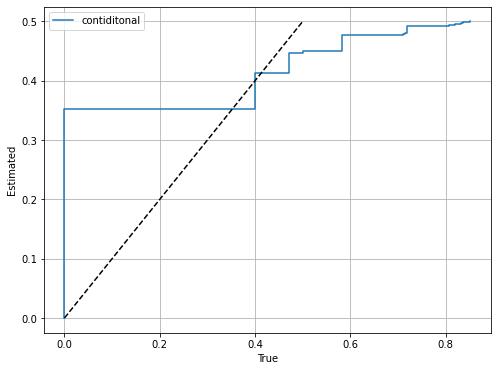

In [150]:
# plot estimated and true q-values
def combine_true_est(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res
        
scores, trues, estimateds = zip(*combine_true_est(q_list_true, q_list_estimated))

import plot_q_vals
plot_q_vals.plot_q_vals( {'contiditonal':(trues,estimateds)})